In [1]:
!pip install -q opendatasets


In [2]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/cdeotte/brain-eeg-spectrograms')
od.download('https://www.kaggle.com/datasets/cdeotte/brain-spectrograms')
od.download('https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: teerawatchitcharoen
Your Kaggle Key: ··········


100%|██████████| 14.9G/14.9G [10:24<00:00, 25.6MB/s]



Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: teerawatchitcharoen
Your Kaggle Key: ··········


100%|██████████| 2.66G/2.66G [01:51<00:00, 25.8MB/s]



Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: teerawatchitcharoen
Your Kaggle Key: ··········


100%|██████████| 18.4G/18.4G [12:11<00:00, 27.0MB/s]



Extracting archive ./hms-harmful-brain-activity-classification/hms-harmful-brain-activity-classification.zip to ./hms-harmful-brain-activity-classification


In [3]:
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd

import albumentations as albu
import matplotlib.pyplot as plt
import os, gc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
df = pd.read_csv('/content/hms-harmful-brain-activity-classification/train.csv')
df.head()

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [5]:
TARGETS = df.columns[-6:]
print('Train shape:', df.shape )
print('Targets', list(TARGETS))

Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


In [6]:
# groupby eeg_id that have been overlap so we just need single spectrogram_id and min offset seconds
train = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg({
                              'spectrogram_id':'first',
                              'spectrogram_label_offset_seconds':'min'})
# new dataframe (add min)
train.columns = ['spec_id','min']

In [7]:
# groupby eeg_id that have been overlap so we just need single spectrogram_id and max offset seconds
tmp = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg({
                            'spectrogram_label_offset_seconds':'max'})
# new dataframe (add max)
train['max'] = tmp

In [8]:
# we only need single patient_id
tmp = df.groupby('eeg_id')[['patient_id']].agg('first')

# new dataframe (add patient_id)
train['patient_id'] = tmp

In [9]:
# avg values each target
tmp = df.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    train[t] = tmp[t].values

# norm values each target
y_data = train[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

# we only need single target per eeg_id
tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train['target'] = tmp

# reset index
train = train.reset_index()
print('Train non-overlapp eeg_id shape:', train.shape )
train.head()

Train non-overlapp eeg_id shape: (17089, 12)


,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


In [ ]:
# PATH = '/home/teerawat.c/projects/HMS_HBAC/datasets/hms-harmful-brain-activity-classification/train_spectrograms/'
# files = os.listdir(PATH)
# print(f'There are {len(files)} spectrogram parquets')

# spectrograms = {}
# for i,f in enumerate(files):
#     if i%100==0: print(i,', ',end='')
#     tmp = pd.read_parquet(f'{PATH}{f}')
#     name = int(f.split('.')[0])
#     spectrograms[name] = tmp.iloc[:,1:].values

In [ ]:
# all_eegs = {}
# for i,e in enumerate(train.eeg_id.values):
#     if i%100==0: print(i,', ',end='')
#     x = np.load(f'/home/teerawat.c/projects/HMS_HBAC/datasets/brain-eeg-spectrograms/EEG_Spectrograms/{e}.npy')
#     all_eegs[e] = x

In [ ]:
spectrograms = np.load('/content/brain-spectrograms/specs.npy',
allow_pickle=True).item()

In [11]:
all_eegs = np.load('/content/brain-eeg-spectrograms/eeg_specs.npy',
allow_pickle=True).item()

In [12]:
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
TARS2 = {x:y for y,x in TARS.items()}

In [13]:
class EEGDataset(Dataset):
    def __init__(self, data, specs, eeg_specs, augment=False, mode='train'):
        self.data = data
        self.specs = specs
        self.eeg_specs = eeg_specs
        self.augment = augment
        self.mode = mode

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        X = np.zeros((128, 256, 8), dtype='float32')  # Adjusted for PyTorch [C, H, W] format
        y = np.zeros(len(TARS), dtype='float32')
        img = np.ones((128, 256), dtype='float32')

        if self.mode == 'test':
            r = 0
        else:
            r = int((row['min'] + row['max']) // 4)

        for k in range(4):
            img = self.specs[row.spec_id][r:r+300, k*100:(k+1)*100].T
            img = np.clip(img, np.exp(-4), np.exp(8))
            img = np.log(img)
            ep = 1e-6
            m = np.nanmean(img.flatten())
            s = np.nanstd(img.flatten())
            img = (img - m) / (s + ep)
            img = np.nan_to_num(img, nan=0.0)
            X[14:-14, :, k] = img[:, 22:-22] / 2.0  # Adjusted for PyTorch [C, H, W] format

        img = self.eeg_specs[row.eeg_id]
        X[:, :, 4:] = img  # Adjusted for PyTorch [C, H, W] format

        if self.mode != 'test':
            y = row[TARGETS]

        X = torch.tensor(X, dtype=torch.float32).permute(2, 0, 1)  # Adjust [H, W, C] to [C, H, W] for PyTorch

        if self.augment:
            X = self.__augment_batch(X)

        y = torch.tensor(y, dtype=torch.float32)
        return X, y

    def __augment_batch(self, img_batch):
        augmented = albu.Compose([
            albu.HorizontalFlip(p=0.5),
            # A.CoarseDropout(max_holes=8, max_height=32, max_width=32, fill_value=0, p=0.5),
        ])(image=img_batch.numpy())['image']  # albumentations works with numpy
        return torch.tensor(augmented, dtype=torch.float32)


In [14]:
# Assuming `data`, `specs`, and `eeg_specs` are defined
dataset = EEGDataset(train, spectrograms, all_eegs, augment=False, mode='train')
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [15]:
len(dataset), dataset.__getitem__(0)

(17089,
 (tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           ...,
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
  
          [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           ...,
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
  
          [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
   

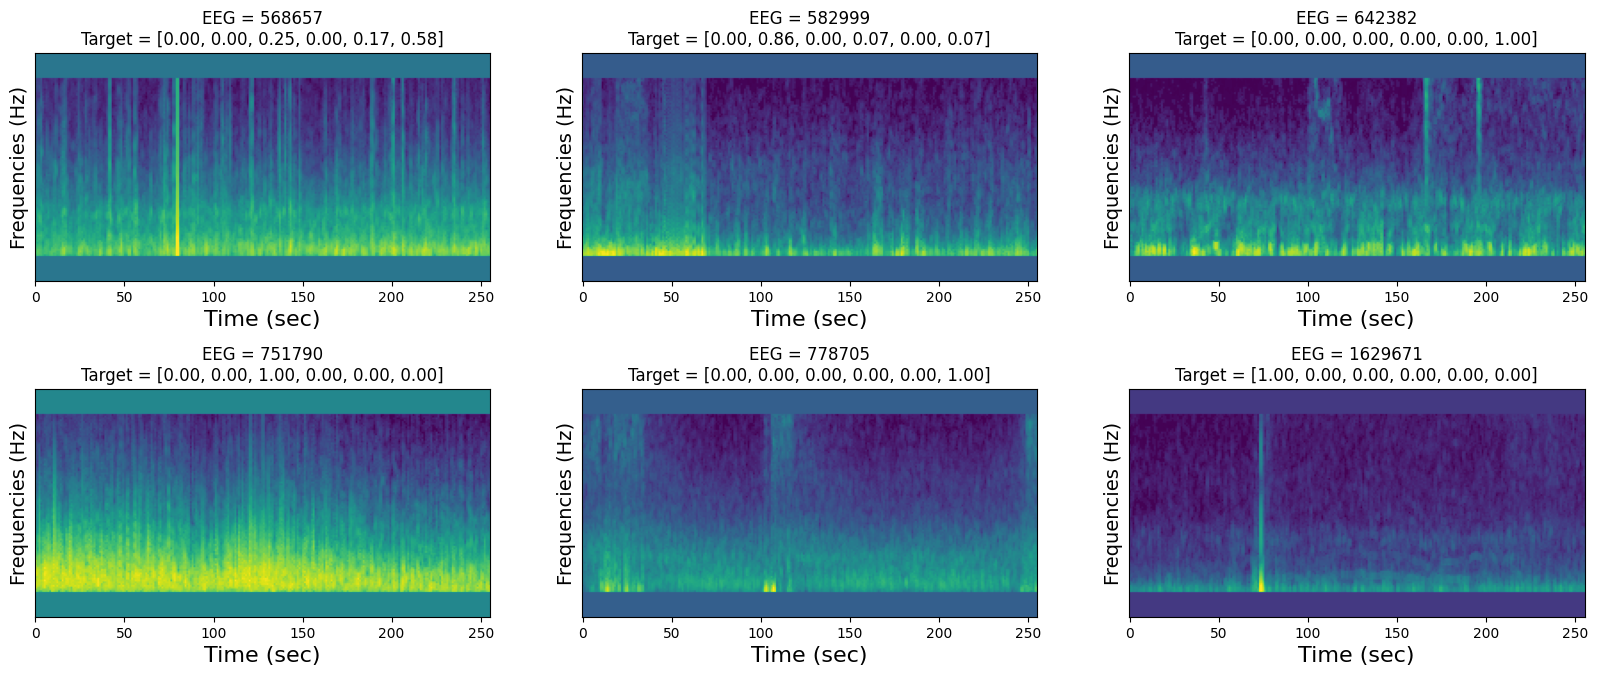

In [16]:
ROWS = 2
COLS = 3
BATCHES = 1

for i, (x, y) in enumerate(dataloader):
    plt.figure(figsize=(20, 8))
    for j in range(ROWS):
        for k in range(COLS):
            plt.subplot(ROWS, COLS, j * COLS + k + 1)

            # Correcting tensor indexing and flipping
            img_tensor = x[j * COLS + k, 0, :, :]  # Get the correct slice of the tensor
            img_tensor = img_tensor.flip(dims=[0])  # Flip the tensor along the first dimension (equivalent to [::-1, ] in NumPy)

            # Convert the tensor to a NumPy array for visualization
            img = img_tensor.numpy()

            # Normalize the image
            mn = img.flatten().min()
            mx = img.flatten().max()
            img = (img-mn)/(mx-mn)

            plt.imshow(img)

            t = y[j * COLS + k].numpy()  # Convert the labels tensor to a NumPy array for processing
            tars = ', '.join([f'{val:0.2f}' for val in t])
            eeg_id = train.eeg_id.values[i*32+j*COLS+k]

            plt.title(f'EEG = {eeg_id}\nTarget = [{tars}]', size=12)
            plt.yticks([])
            plt.ylabel('Frequencies (Hz)', size=14)
            plt.xlabel('Time (sec)', size=16)

    plt.show()
    if i == BATCHES - 1:
        break

In [17]:
dataset = EEGDataset(train, spectrograms, all_eegs, augment=False, mode='train')

valid_size = int(0.2 * len(dataset))  # for a 80-20 split
train_size = len(dataset) - valid_size

In [18]:
train_size, valid_size

(13672, 3417)

In [19]:
from torch.utils.data import random_split
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

In [20]:
training_loader = DataLoader(train_dataset, shuffle=True, batch_size=32)
validation_loader = DataLoader(valid_dataset, shuffle=False, batch_size=64)

In [21]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 62.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 7

In [22]:
from efficientnet_pytorch import EfficientNet

class CustomEfficientNet(nn.Module):
    def __init__(self):
        super(CustomEfficientNet, self).__init__()

        # Load EfficientNet
        self.base_model = EfficientNet.from_pretrained('efficientnet-b0')

        # Adjusting EfficientNet to accept 512x512 input
        # Note: EfficientNet automatically adjusts its internal input processing to match the input size

        # Final classification layer
        self.pooling = nn.AdaptiveAvgPool2d(1)  # Global average pooling
        self.output_layer = nn.Linear(self.base_model._fc.in_features, 6)

    def forward(self, x):
        # Input x is expected to be of shape [batch_size, channels, height, width]
        # Adjust input tensor to create a 3-channel image
        x1 = x[:, :4, :, :]
        x2 = x[:, 4:, :, :]
        x1 = x1.reshape(x1.shape[0], 1, -1, x1.shape[3])  # Concatenate along height
        x2 = x2.reshape(x2.shape[0], 1, -1, x2.shape[3])  # Concatenate along height
        x = torch.cat((x1, x2), dim=2)  # Concatenate along width

        x = x.repeat(1, 3, 1, 1)  # Repeat the single channel 3 times to mimic 3-channel RGB

        # EfficientNet
        x = self.base_model.extract_features(x)

        # Pooling and output
        x = self.pooling(x).squeeze(-1).squeeze(-1)
        x = self.output_layer(x)

        return x

In [23]:
import torchvision.transforms as transforms

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

from sklearn.metrics import accuracy_score, f1_score

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
EfficientNet = CustomEfficientNet().to(device)
print(f"Model is using device: {device}", f"{EfficientNet.output_layer}")

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 45.2MB/s]


Loaded pretrained weights for efficientnet-b0
Model is using device: cuda Linear(in_features=1280, out_features=6, bias=True)


In [25]:
from sklearn.metrics import accuracy_score, f1_score
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class ModelTraining():
    def __init__(self, Epoch, model):
        self.Epochs = Epoch
        self.model = model
        self.epoch_number = 0
        self.best_weight = None
        self.best_vloss = 1_000_000.

        self.val_losses = []
        self.acc_history = []
        self.train_losses = []

        # lr_list: 0.0001, 0.001, 0.0008, 0.008
        # self.optimizer = torch.optim.SGD(self.model.parameters(), lr=0.001, momentum=0.9)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.0001)

        # We’ll be using a cross-entropy loss. For demonstration purposes.
        self.loss_fn = torch.nn.CrossEntropyLoss()

        self.classes_ident = nn.Softmax(dim=1)

    def train_one_epoch(self, epoch_index, tb_writer):
        running_loss = 0.
        last_loss = 0.

        # Here, we use enumerate(training_loader) instead of
        # iter(training_loader) so that we can track the batch
        # index and do some intra-epoch reporting
        for i, data in enumerate(training_loader):
            # Every data instance is an input + label pair
            inputs, labels = data

            # Zero your gradients for every batch!
            self.optimizer.zero_grad()

            # Make predictions for this batch
            outputs = self.model(inputs.to(device))

            outputs = self.classes_ident(outputs)
            labels = self.classes_ident(labels.to(device))

            # Compute the loss and its gradients
            loss = self.loss_fn(outputs, labels)
            loss.backward()

            # Adjust learning weights
            self.optimizer.step()

            # Gather data and report
            running_loss += loss.item()
            if i % 1000 == 999:
                last_loss = running_loss / 1000 # loss per batch
                print('  batch {} loss: {}'.format(i + 1, last_loss))
                tb_x = epoch_index * len(training_loader) + i + 1
                tb_writer.add_scalar('Loss/train', last_loss, tb_x)
                running_loss = 0.

        return last_loss

    def TrainStart(self):
      print(f'Start Experiment')
      timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
      writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
      for epoch in range(self.Epochs):
        print('EPOCH {}:'.format(self.epoch_number + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        self.model.train(True)
        avg_loss = self.train_one_epoch(self.epoch_number, writer)
        self.train_losses.append(avg_loss)

        running_vloss = 0.0
        # Set the model to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.
        self.model.eval()

        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():

            predicted_labels = []
            true_labels = []

            for i, vdata in enumerate(validation_loader):
                vinputs, vlabels = vdata
                voutputs = self.model(vinputs.to(device))
                vloss = self.loss_fn(voutputs, vlabels.to(device))
                running_vloss += vloss

                # Get predicted labels
                pred_labels = self.classes_ident(voutputs).argmax(dim=1).cpu().numpy()
                vlabels = self.classes_ident(vlabels).argmax(dim=1).cpu().numpy()

                # Update lists
                true_labels.extend(vlabels)
                predicted_labels.extend(pred_labels)

        accuracy = accuracy_score(true_labels, predicted_labels)
        avg_vloss = running_vloss / (i + 1)
        self.val_losses.append(avg_vloss.cpu())
        self.acc_history.append(accuracy)
        print('LOSS train {} valid {} accuracy {}'.format(avg_loss, avg_vloss, accuracy))

        # Log the running loss averaged per batch
        # for both training and validation
        writer.add_scalars('Training vs. Validation Loss', { 'Training' : avg_loss, 'Validation' : avg_vloss, 'Accuracy' : accuracy }, self.epoch_number + 1)
        writer.flush()

        # Track best performance, and save the model's state
        if avg_vloss < self.best_vloss:
            self.best_vloss = avg_vloss
            self.best_weight = self.model.state_dict()

        self.epoch_number += 1

In [26]:
EfficientNet_log = ModelTraining(20, EfficientNet)
EfficientNet_log.TrainStart()

Start Experiment
EPOCH 1:
LOSS train 0.0 valid 1.287201166152954 accuracy 0.5616037459760024
EPOCH 2:
LOSS train 0.0 valid 0.9121614694595337 accuracy 0.7216856892010536
EPOCH 3:
LOSS train 0.0 valid 0.9287371635437012 accuracy 0.7123207491952005
EPOCH 4:
LOSS train 0.0 valid 0.9370930194854736 accuracy 0.7292947029558092
EPOCH 5:
LOSS train 0.0 valid 0.9035387635231018 accuracy 0.7287093942054433
EPOCH 6:
LOSS train 0.0 valid 0.9135956764221191 accuracy 0.7275387767047118
EPOCH 7:
LOSS train 0.0 valid 0.8957948684692383 accuracy 0.7439274217149546
EPOCH 8:
LOSS train 0.0 valid 0.9246008396148682 accuracy 0.7322212467076383
EPOCH 9:
LOSS train 0.0 valid 0.9426872730255127 accuracy 0.7456833479660521
EPOCH 10:
LOSS train 0.0 valid 0.9002017378807068 accuracy 0.7380743342112964
EPOCH 11:
LOSS train 0.0 valid 0.9008383750915527 accuracy 0.743049458589406
EPOCH 12:
LOSS train 0.0 valid 0.9265933036804199 accuracy 0.7439274217149546
EPOCH 13:
LOSS train 0.0 valid 0.9309406280517578 accuracy

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
epoch = EfficientNet_log.Epochs - 1

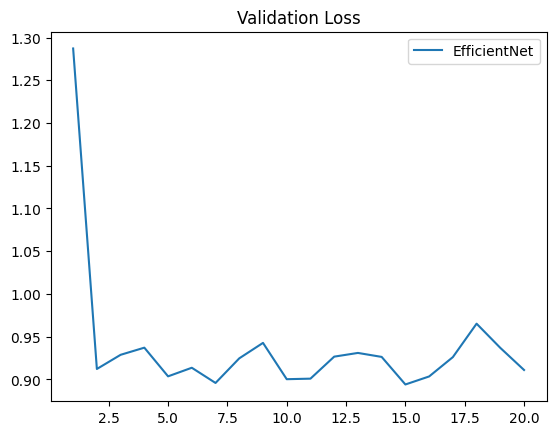

In [28]:
plt.title("Validation Loss")
plt.plot(np.arange(1, epoch+2), np.array(EfficientNet_log.val_losses), label='EfficientNet')
# plt.plot(np.arange(1, epoch+2), np.array(resnet18_log.val_losses), label='resnet18_valid')
plt.legend()

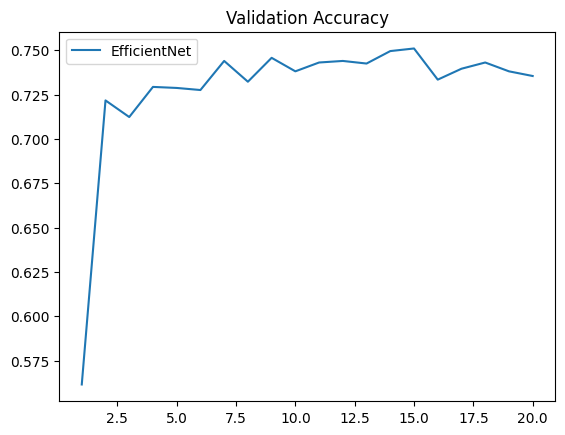

In [29]:
plt.title("Validation Accuracy")
plt.plot(np.arange(1, epoch+2), np.array(EfficientNet_log.acc_history), label='EfficientNet')
# plt.plot(np.arange(1, epoch+2), np.array(resnet18_log.acc_history), label='resnet18_accuracy')
plt.legend()

In [30]:
EfficientNet.load_state_dict(EfficientNet_log.best_weight)
EfficientNet.eval()
print('Done! Model is loaded...: {}'.format(EfficientNet))

Done! Model is loaded...: CustomEfficientNet(
  (base_model): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_pr

In [34]:
loss_fn = torch.nn.CrossEntropyLoss()
classes_ident = nn.Softmax(dim=1)

In [38]:
torch.save(EfficientNet.state_dict(), "model_weights.pth")
torch.cuda.empty_cache()

In [46]:
torch.cuda.memory_stats()

OrderedDict([('active.all.allocated', 13326614),
             ('active.all.current', 1051),
             ('active.all.freed', 13325563),
             ('active.all.peak', 1224),
             ('active.large_pool.allocated', 5661020),
             ('active.large_pool.current', 50),
             ('active.large_pool.freed', 5660970),
             ('active.large_pool.peak', 160),
             ('active.small_pool.allocated', 7665594),
             ('active.small_pool.current', 1001),
             ('active.small_pool.freed', 7664593),
             ('active.small_pool.peak', 1211),
             ('active_bytes.all.allocated', 594186988240384),
             ('active_bytes.all.current', 16115024896),
             ('active_bytes.all.freed', 594170873215488),
             ('active_bytes.all.peak', 16115024896),
             ('active_bytes.large_pool.allocated', 593853871934464),
             ('active_bytes.large_pool.current', 16062803968),
             ('active_bytes.large_pool.freed', 593837809130

In [48]:
predicted_labels = []
true_labels = []

for i, vdata in enumerate(validation_loader):
    vinputs, vlabels = vdata
    with torch.no_grad():
      voutputs = EfficientNet(vinputs.to(device))

      # Get predicted labels
      pred_labels = classes_ident(voutputs).argmax(dim=1).cpu().numpy()
      vlabels = classes_ident(vlabels).argmax(dim=1).cpu().numpy()

      # Update lists
      true_labels.extend(vlabels)
      predicted_labels.extend(pred_labels)

# Calculate mean accuracy
accuracy_EfficientNet = accuracy_score(true_labels, predicted_labels)

In [50]:
print("classification report EfficientNet")
print(classification_report(true_labels,predicted_labels,target_names=list(TARGETS)))

classification report EfficientNet
              precision    recall  f1-score   support

seizure_vote       0.80      0.70      0.75       545
    lpd_vote       0.77      0.72      0.75       527
    gpd_vote       0.72      0.82      0.77       320
   lrda_vote       0.41      0.28      0.34       197
   grda_vote       0.58      0.66      0.62       359
  other_vote       0.78      0.81      0.79      1469

    accuracy                           0.74      3417
   macro avg       0.68      0.67      0.67      3417
weighted avg       0.73      0.74      0.73      3417



confusion matrix EfficientNet


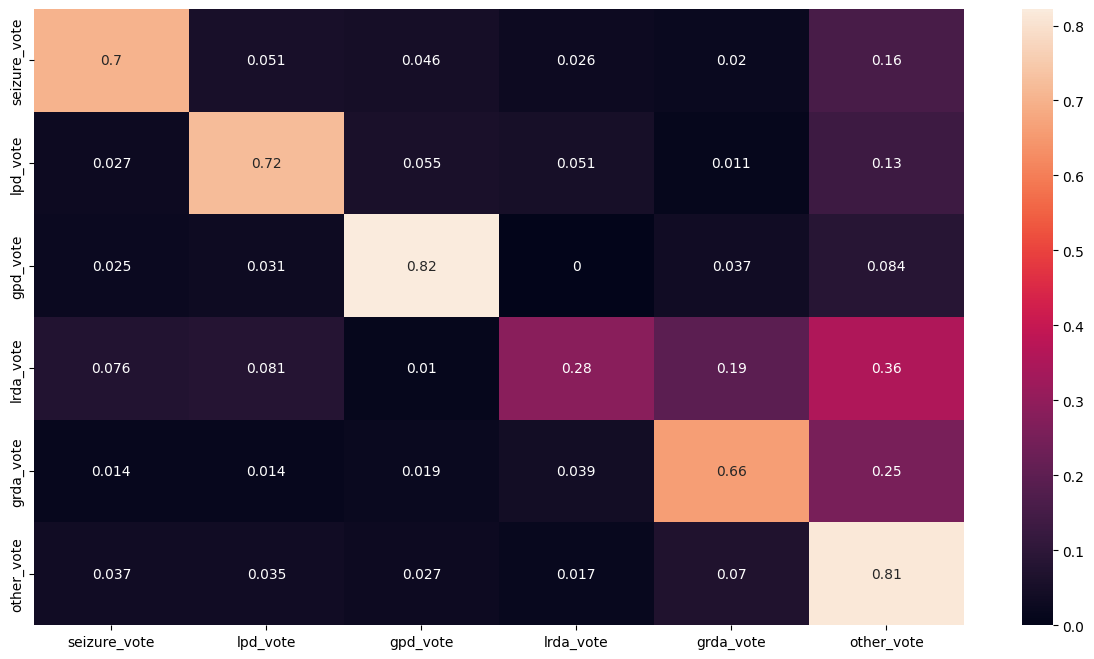

In [51]:
print("confusion matrix EfficientNet")
matrix = confusion_matrix(true_labels,predicted_labels,normalize="true")
plt.figure(figsize=(15,8))
sns.heatmap(matrix,annot=True, xticklabels=list(TARGETS), yticklabels=list(TARGETS))
plt.show()